In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
house_df_org=pd.read_csv('house_price.csv')
house_df=house_df_org.copy()
house_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house_df.shape

(1460, 81)

In [6]:
house_df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [10]:
house_df.isnull().sum()[house_df.isnull().sum()>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

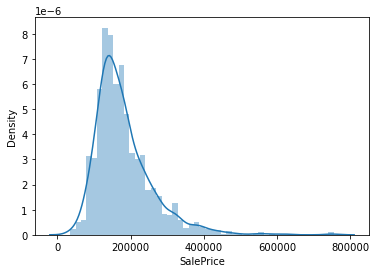

In [11]:
sns.distplot(house_df['SalePrice'])

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

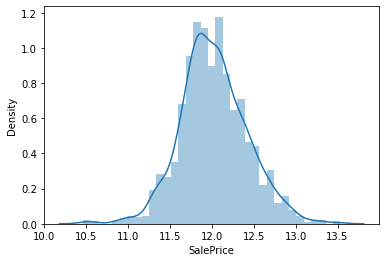

In [12]:
log_SalePrice=np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

In [9]:
org_SalePrice=house_df['SalePrice']
house_df['SalePrice']=np.log1p(house_df['SalePrice'])

house_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'],axis=1,inplace=True)

house_df.fillna(house_df.mean(),inplace=True) #드롭하지 않는 null 칼럼은 평균으로

In [10]:
null_col=house_df.isnull().sum()[house_df.isnull().sum()>0]

house_df.dtypes[null_col.index]

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object

In [11]:
house_df_one=pd.get_dummies(house_df)

In [12]:
house_df_one.shape

(1460, 271)

In [13]:
null_col=house_df_one.isnull().sum()[house_df_one.isnull().sum()>0]

house_df_one.dtypes[null_col.index]

Series([], dtype: object)

### 선형 회귀 모델 학습/예측/평가

In [14]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_one['SalePrice']
X_features = house_df_one.drop('SalePrice',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.01
Ridge 로그 변환된 RMSE: 0.01
Lasso 로그 변환된 RMSE: 0.022


[0.010095003966137517, 0.009695619829704336, 0.02230653379455126]

﻿회귀 계수값의 상위 10개, 하위 10개의 피처명과 그 회귀 계수 값을 가지는 판다스 시리즈 객체를 반환하는 함수 생성

In [16]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low


시각화를 위한 함수 생성

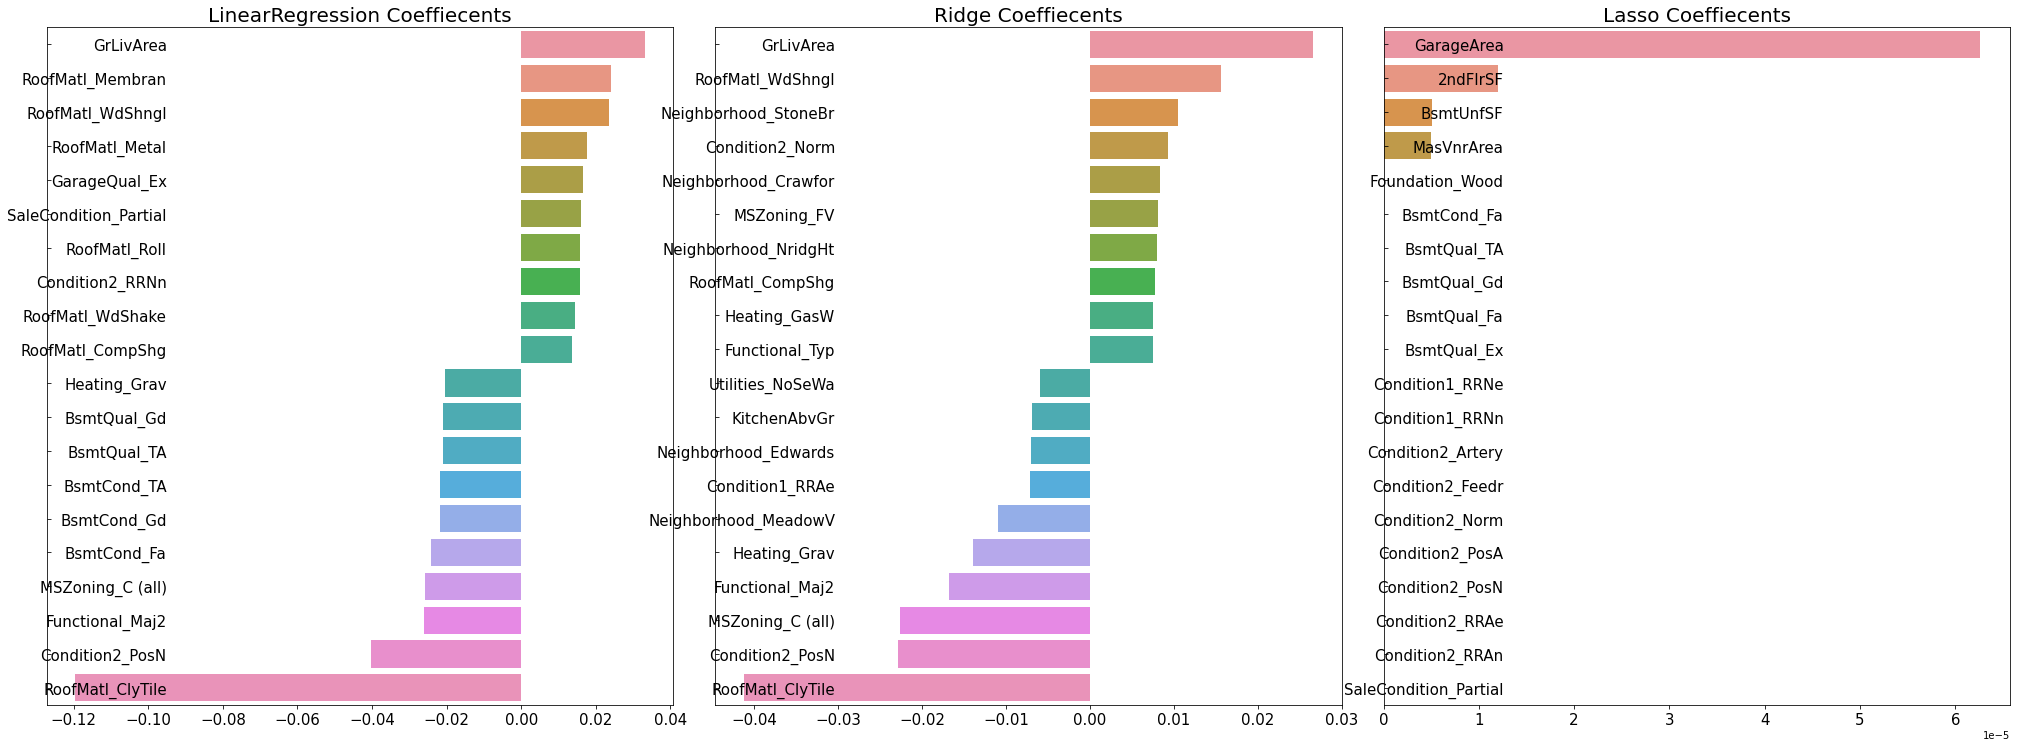

In [17]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(28,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=20)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(15)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)


In [18]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.01  0.011 0.012 0.009 0.012]
LinearRegression CV 평균 RMSE 값: 0.011

Ridge CV RMSE 값 리스트: [0.009 0.011 0.011 0.009 0.012]
Ridge CV 평균 RMSE 값: 0.01

Lasso CV RMSE 값 리스트: [0.021 0.024 0.023 0.022 0.022]
Lasso CV 평균 RMSE 값: 0.022


최적 alpha값 찾는 함수

In [19]:

from sklearn.model_selection import GridSearchCV

def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)


Ridge 5 CV 시 최적 평균 RMSE 값: 0.0099, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.0123, 최적 alpha:{'alpha': 0.001}


﻿선형 모델에 최적 alpha값을 설정한 뒤 train_test_split()으로 분할된 학습 데이터와 테스트 데이터를 이용해 모델의 학습/예측/평가를 수행하고 회귀계수 시각화

LinearRegression 로그 변환된 RMSE: 0.01
Ridge 로그 변환된 RMSE: 0.01
Lasso 로그 변환된 RMSE: 0.012


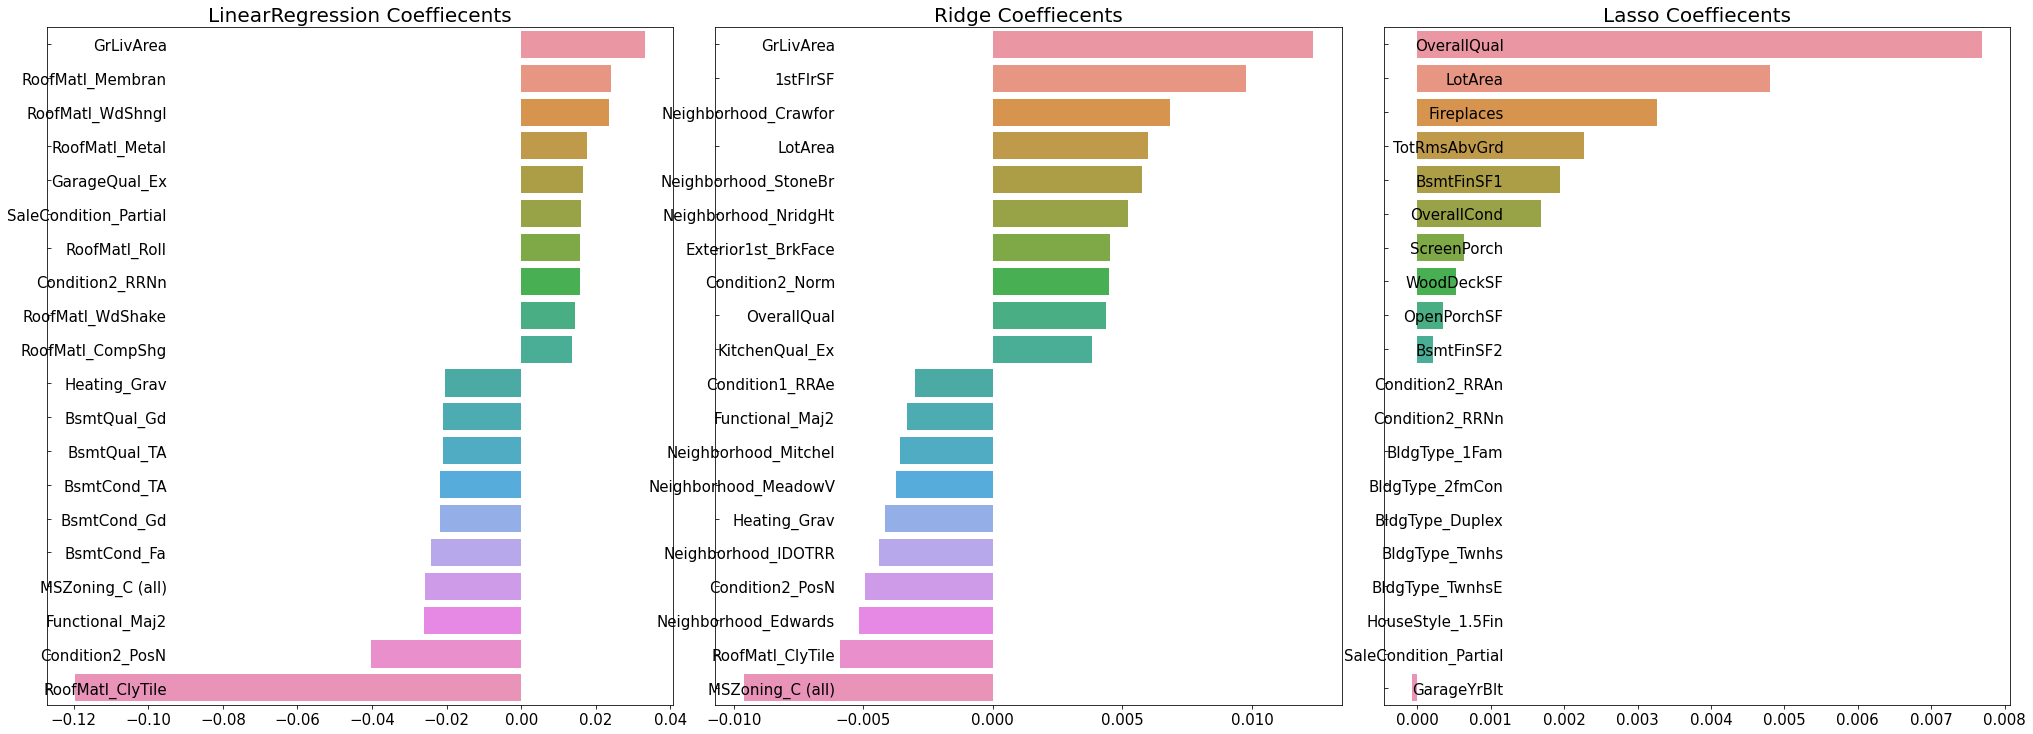

In [20]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- 피처 데이터 세트의 데이터 분포도

In [21]:
from scipy.stats import skew

# object가 아닌 숫자형 피쳐의 컬럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

# house_df에 컬럼 index를 [ ]로 입력하면 해당하는 컬럼 데이터 셋 반환. apply lambda로 skew( )호출 
skew_features = house_df[features_index].apply(lambda x : skew(x))

# skew 정도가 1 이상인 컬럼들만 추출. 
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

PoolArea         14.348342
3SsnPorch         7.727026
LowQualFinSF      7.452650
MiscVal           5.165390
BsmtHalfBath      3.929022
KitchenAbvGr      3.865437
ScreenPorch       3.147171
MasVnrArea        2.673661
BsmtFinSF2        2.521100
LotFrontage       2.382499
EnclosedPorch     2.110104
dtype: float64


In [22]:
house_df[skew_features_top.index]=np.log1p(house_df[skew_features_top.index])

In [23]:
# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성,
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_one['SalePrice']
X_features = house_df_one.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.0099, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.0123, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.01
Ridge 로그 변환된 RMSE: 0.01
Lasso 로그 변환된 RMSE: 0.012


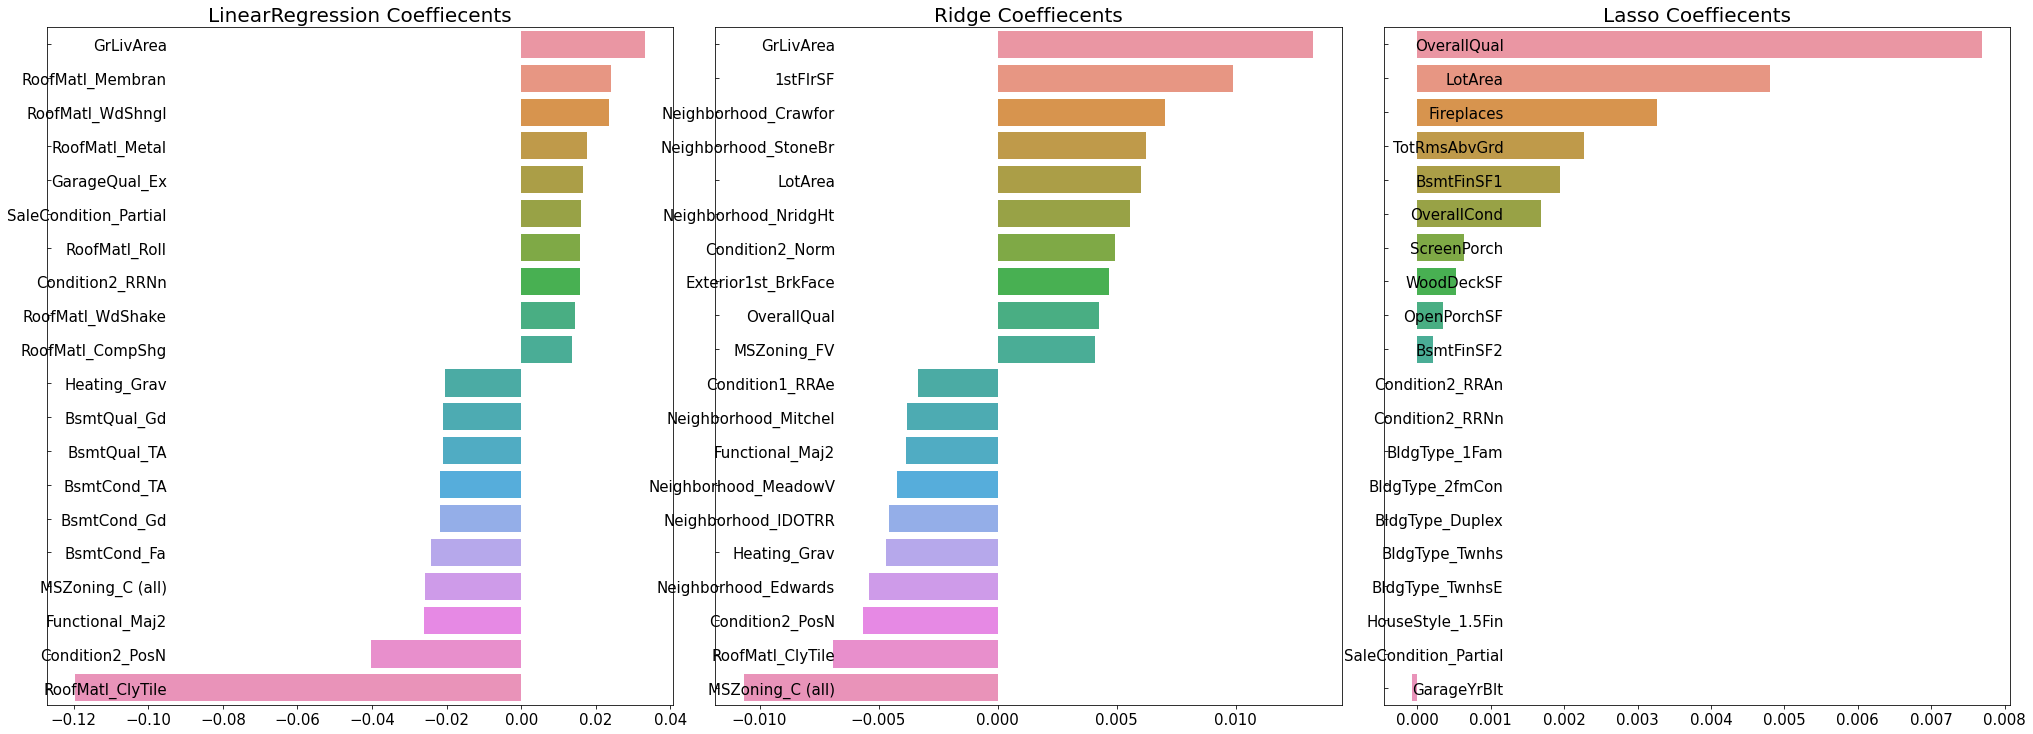

In [24]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

이상치 데이터

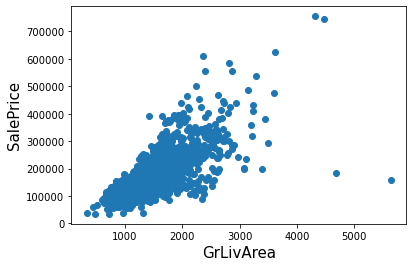

In [25]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()


In [26]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성. 
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제. 
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

아웃라이어 레코드 index : [ 523  691 1182 1298]
아웃라이어 삭제 전 house_df_ohe shape: (1460, 271)
아웃라이어 삭제 후 house_df_ohe shape: (1456, 271)


In [27]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.0088, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.0114, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.01
Ridge 로그 변환된 RMSE: 0.009
Lasso 로그 변환된 RMSE: 0.012


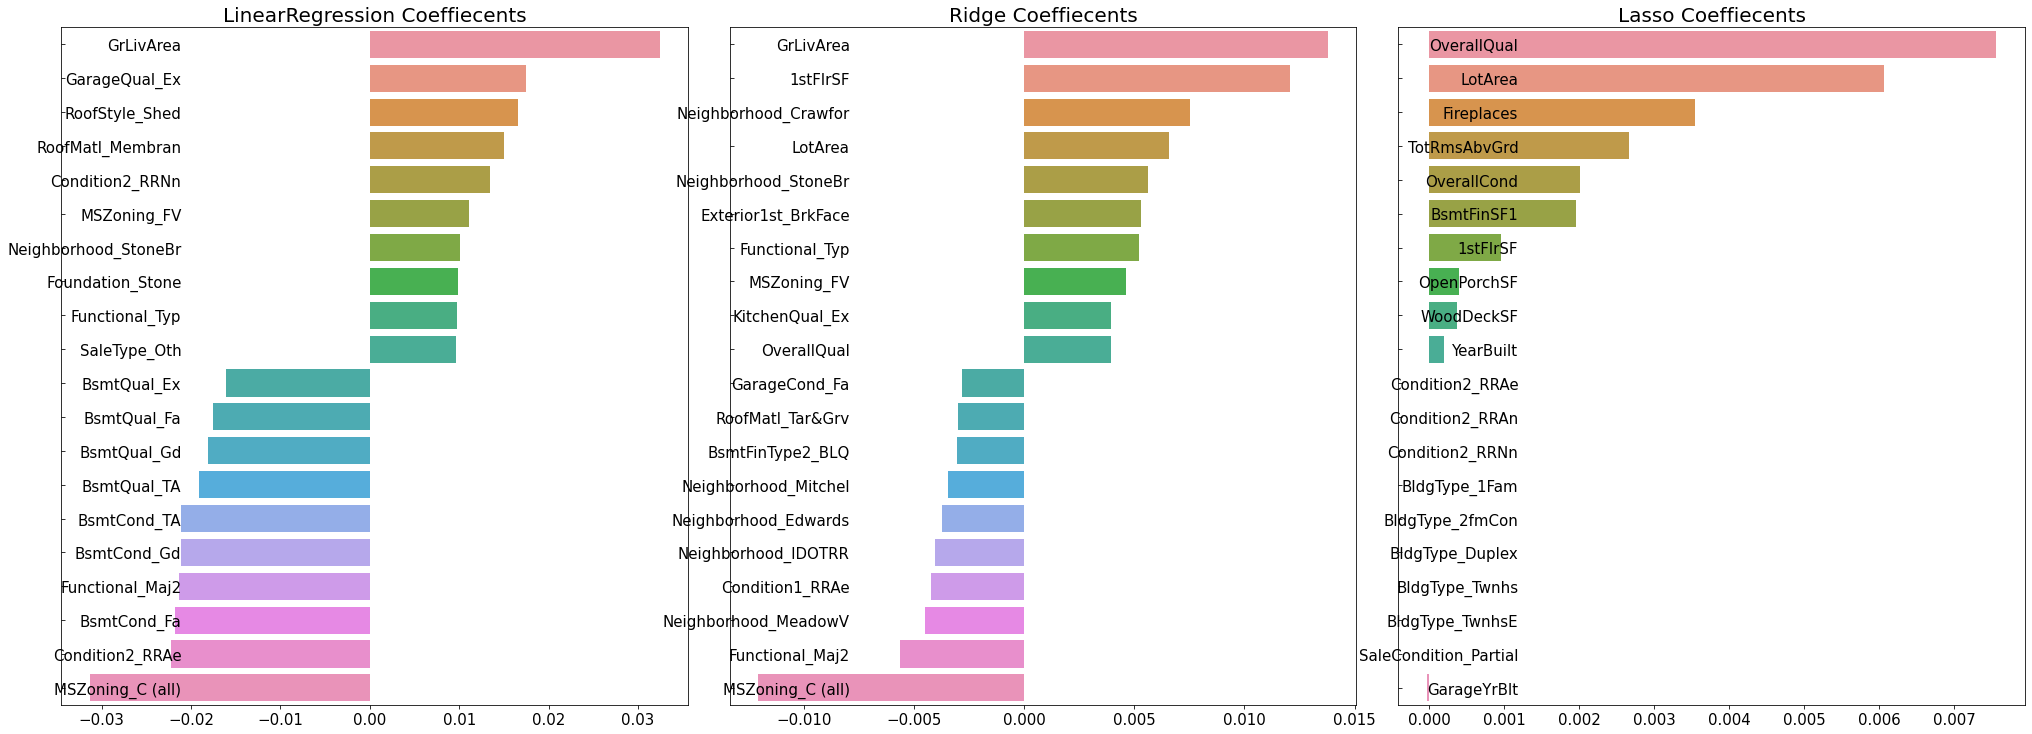

In [28]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 회귀 트리 모델 학습/예측/평가

In [29]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = get_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.0093, 최적 alpha:{'n_estimators': 1000}


In [30]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = get_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.0091, 최적 alpha:{'n_estimators': 1000}


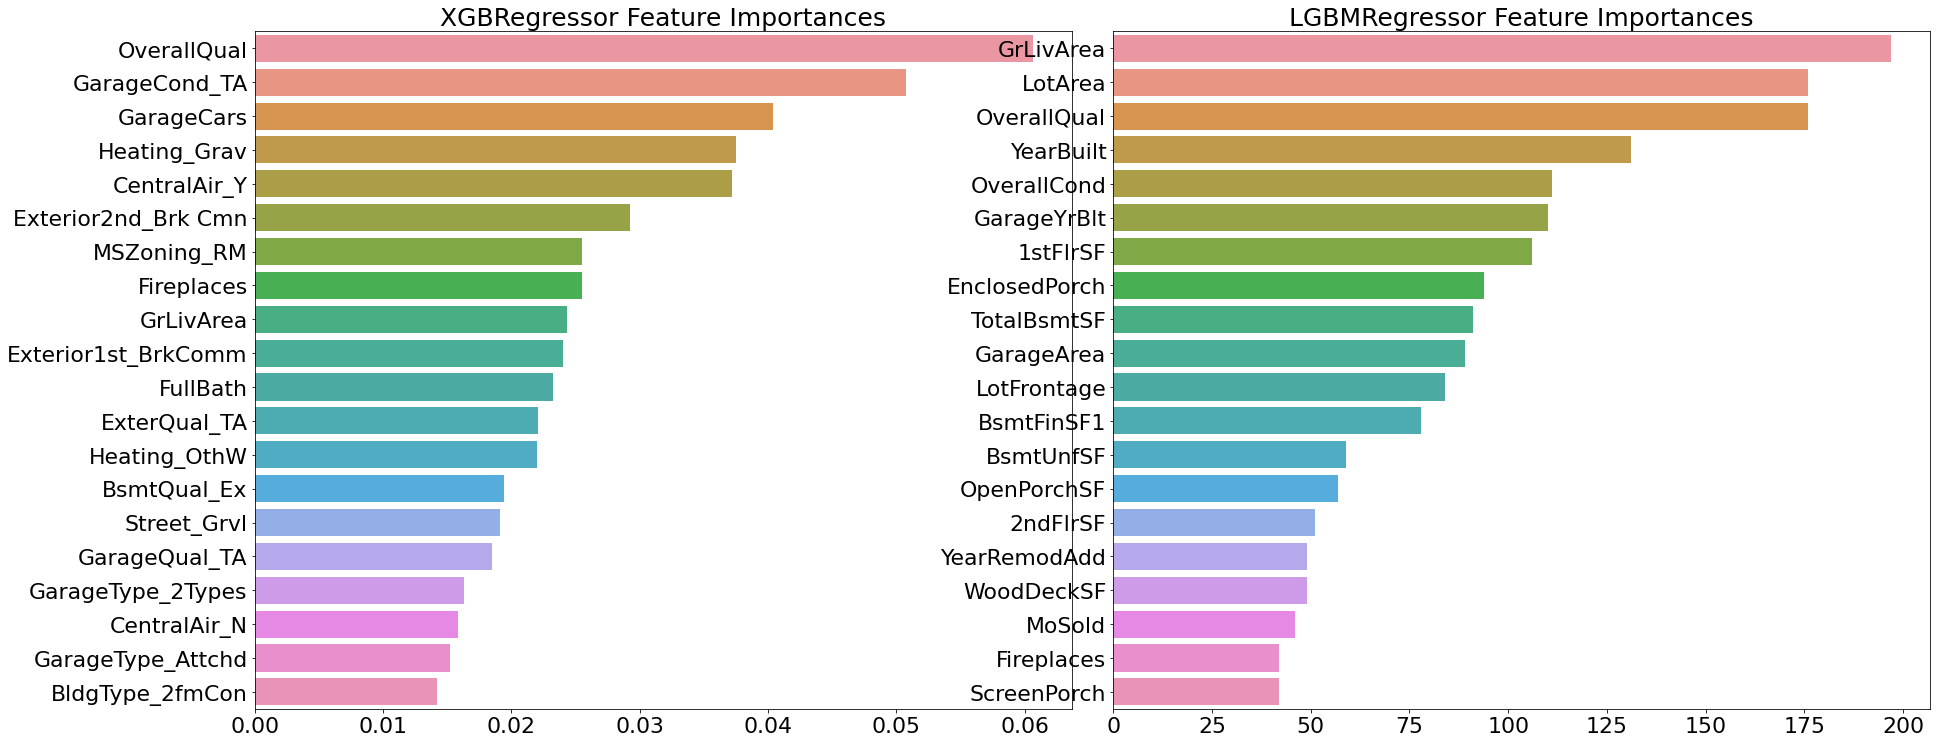

In [31]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 get_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)


### 회귀 모델의 예측 결과 혼합을 통한 최종 예측

In [32]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)


최종 혼합 모델의 RMSE: 0.010385135682880697
Ridge 모델의 RMSE: 0.009324284436651023
Lasso 모델의 RMSE: 0.011963938412961108


In [33]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)


최종 혼합 모델의 RMSE: 0.009383588886636795
XGBM 모델의 RMSE: 0.009918871122250197
LGBM 모델의 RMSE: 0.009314627356088004


In [37]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [38]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)



Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [39]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)



스태킹 회귀 모델의 최종 RMSE 값은: 0.021351483340151623
